<a href="https://colab.research.google.com/github/MickaRiv/ProjetDatascientest-VoiceSeparator/blob/Stan/notebooks/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs et imports

In [1]:
!pip install nussl

     |████████████████████████████████| 239 kB 5.3 MB/s 
     |████████████████████████████████| 240 kB 51.7 MB/s 
     |████████████████████████████████| 310 kB 52.3 MB/s 
     |████████████████████████████████| 3.3 MB 27.7 MB/s 
     |████████████████████████████████| 51 kB 20 kB/s 
     |████████████████████████████████| 146 kB 33.7 MB/s 
     |████████████████████████████████| 71 kB 167 kB/s 
     |████████████████████████████████| 87 kB 6.4 MB/s 
     |████████████████████████████████| 963 kB 40.2 MB/s 
     |████████████████████████████████| 130 kB 33.6 MB/s 
     |████████████████████████████████| 6.2 MB 28.9 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=76740c7e9913cb9dc7aacf19cafbfe70d17ce680d6f9ad06a199cae01701cb6b
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509894 sha256=894c5065f2a34c8e0be8d6

In [2]:
!pip install git+https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator

  Cloning https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator to /tmp/pip-req-build-xo0zi2il
  Running command git clone -q https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator /tmp/pip-req-build-xo0zi2il
  Created wheel for voice-separator: filename=voice_separator-0.0.1-py3-none-any.whl size=5583 sha256=aa63307ba4b8e4e990d391cc8dd40cca43fd2ccc9ab98dec0da119c2bc35d9cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-n4qybjtc/wheels/89/ad/91/9cded351057b1a842fbbfa97f091da426d85036b0efd2e0273
Successfully built voice-separator


In [8]:
import os
import nussl
import librosa
from matplotlib import pyplot as plt
import numpy as np

# Montage du drive

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Récupération des données

In [5]:
from voicesep.core import get_musdb_data

path = os.path.join("/content",
                    "drive",
                    "MyDrive",
                    "Projet Datascientest",
                    "musdb18")
musdb = get_musdb_data(gather_accompaniment=True,folder=path)
musdb_train = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="train")
musdb_test = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="test")

Ces variables sont des hooks dataset, et pas directement l'entièreté des données (pour ne pas exploser la RAM). Il est possible d'accéder aux items du dataset par le getitem python classique : `musdb[i]`.

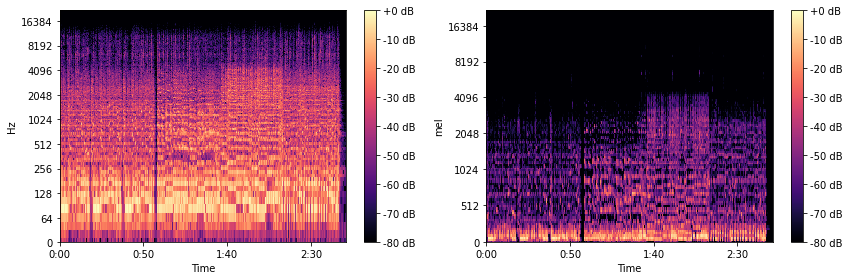

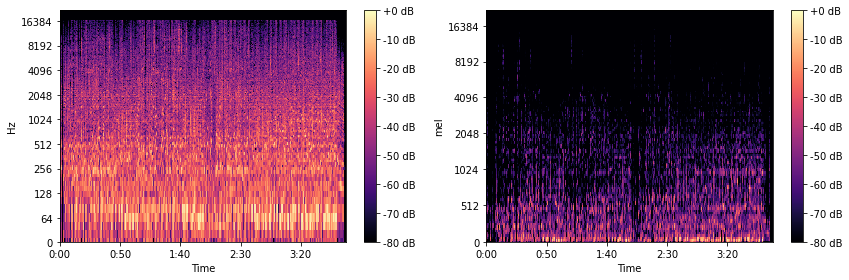

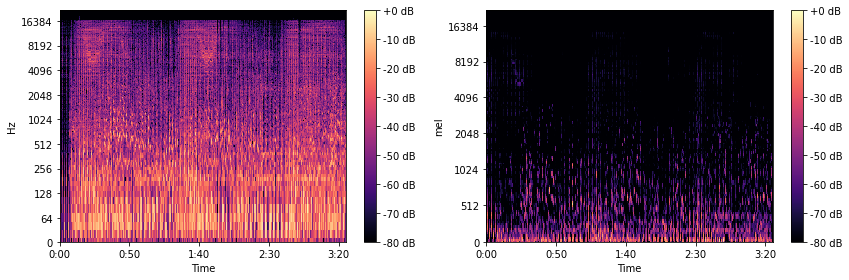

In [ ]:
for i in range(3):
  plt.figure(figsize=(12,4))

  plt.subplot(121)
  nussl.core.utils.visualize_spectrogram(musdb[i]['mix'],y_axis='log')
  plt.colorbar(format='%+2.0f dB')

  plt.subplot(122)
  nussl.core.utils.visualize_spectrogram(musdb[i]['mix'],y_axis="mel")
  plt.colorbar(format='%+2.0f dB')
  plt.ylabel("mel")
  plt.tight_layout()
  plt.show()

# Spectrogrammes et création du dataset

On calcule les spectrogrammes du mix (données d'entrée) et du vocals (ground truth). Les spectres sont concaténés puis découpés pour former une "image" (donnée d'entrée du U-net).
Rem. : faire une fonction, ce serait plus propre

In [23]:
# nombres de pistes pour le train
pistes=range(4)


# paramètres de la STFT
freq_origin =44100     # fréquence d'échantillonage d'origine
freq        =16000     # fréquence de réechantillonage

window_length =2048    # taille fenêtre FFT
hop_length    =512     # recouvrement FFT

patch_size = 128      # taille du patch temporel pour le CNN (=128 frames temporels)

path_train=path+'/train'

print(path_train)
files = librosa.util.find_files(path_train)
print(files)
ymix = []

for npiste in pistes:

  voice=musdb[npiste]['sources']["vocals"]
#  mix=musdb[npiste]['mix']

# réechantillonnage à 16 kHz
  print(voice.shape())

  voice = librosa.resample(voice,freq_origin,freq)
  mix   = librosa.resample(mix,freq_origin,freq)

# fft mix et voix
  stft = librosa.stft(mix,n_fft=window_size,hop_length=hop_length)
  mag, phase = librosa.magphase(stft)

  ymix.append(mag)
 

print('fini')




k=0
time=0
for npiste in pistes:

#spectro voix et mix
  voice=musdb[npiste]['sources']["vocals"]
  mix=musdb[npiste]['mix']

  voice.stft_params = nussl.STFTParams(window_length=window_length, hop_length=hop_length)
  mix.stft_params = nussl.STFTParams(window_length=window_length, hop_length=hop_length)

  stft_mix   = mix.stft()
  stft_voice = voice.stft()

  time=time+voice.audio_data.shape[1]/voice.sample_rate 

# nombre de bins en fréquence
  nfreq0      =stft_mix.shape[0]

# on peut "sous-échantilloner" en ne prenant qu'une partie de ces données
  nfreq      =int(nfreq0/2)

# passage en mono, en amplitude et normalisation 
  mono=(stft_mix[:nfreq,:,0]+stft_mix[:nfreq,:,1])/2.

  mono=np.abs(mono)  # norme
  spectro_mix=mono/mono.max() 
  phase_mix=np.angle(mono)  # phase du mix (utile pour la reconstruction)

  
  mono=(stft_voice[:nfreq,:,0]+stft_voice[:nfreq,:,1])/2.
  mono=np.abs(mono)

  spectro_voice=mono/mono.max() 

# concatenation
  k=k+1
  if (k==1):
    X_mix   =spectro_mix
    X_voice =spectro_voice
    phase   =phase_mix
  else:
    X_mix  =np.append(X_mix,spectro_mix,axis=1)
    X_voice=np.append(X_voice,spectro_voice,axis=1)
    phase  =np.append(phase,phase_mix,axis=1)
  
# transposition pour mettre le temps en première composante  
X_mix=X_mix.T
X_voice=X_voice.T
phase=phase.T

# split en "images" temporelles de taille nframe
nframes=128

nimages=X_mix.shape[0]//nframes   # nombre total d'images
newsize=nimages*nframes           # nouvelle taille pour un découpage qui tombe juste 

print('Data set: ',k, 'songs')
print('Data set: ',time, 'total time (s)')
print('Data set: ',nimages, 'training images with size',nframes,'x',nfreq)

X_mix_resized  =X_mix  [:newsize,:]
X_voice_resized=X_voice[:newsize,:]
phase_resized=phase[:newsize,:]

X_mix=np.array(np.split(X_mix_resized, nimages, axis=0))    # découpage 
X_voice=np.array(np.split(X_voice_resized, nimages, axis=0))
phase=np.array(np.split(phase_resized, nimages, axis=0))

X_mix=np.expand_dims(X_mix,axis=3) # rajout d'une dimension (canal) 
X_voice=np.expand_dims(X_voice,axis=3)


/content/drive/MyDrive/Projet Datascientest/musdb18/train
[]


AttributeError: ignored

# Création du U-Net

U-Net tiré de Jansson et al.

Input: "image" de spectrogramme : taille nframes x nfreq
(papier d'origine nframes=128 et nfreq=512)

Output: Mask M (0/1) de même dimension

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose , Dropout, Concatenate,  LeakyReLU, ReLU

# Rem. dimensionnement du papier  nframes=128 nfreq=512


# Création de la structure

inputs=Input(shape =(nframes,nfreq,1) )

conv1 = Conv2D(filters = 16, kernel_size = (5,5) , strides=2, padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=0.2)(conv1)

conv2 = Conv2D(filters = 32, kernel_size = (5,5), strides=2, padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=0.2)(conv2)

conv3 = Conv2D(filters = 64, kernel_size = (5,5), strides=2, padding='same')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU(alpha=0.2)(conv3)

conv4 = Conv2D(filters = 128, kernel_size = (5,5), strides=2, padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU(alpha=0.2)(conv4)

conv5 = Conv2D(filters = 256, kernel_size = (5,5), strides=2, padding='same')(conv4)
conv5 = BatchNormalization()(conv5)
conv5 = LeakyReLU(alpha=0.2)(conv5)

conv6 = Conv2D(filters = 512, kernel_size = (5,5), strides=2, padding='same')(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = LeakyReLU(alpha=0.2)(conv6)

deconv7 = Conv2DTranspose(filters = 256, kernel_size = (5,5), strides=2, padding='same')(conv6)
deconv7 = BatchNormalization()(deconv7)
deconv7 = Dropout(0.5)(deconv7)
deconv7 = ReLU()(deconv7)
deconv7 = Concatenate(axis=3)([deconv7, conv5])

deconv8 = Conv2DTranspose(filters = 128, kernel_size = (5,5), strides=2, padding='same')(deconv7)
deconv8 = BatchNormalization()(deconv8)
deconv8 = Dropout(0.5)(deconv8)
deconv8 = ReLU()(deconv8)
deconv8 = Concatenate(axis=3)([deconv8, conv4])

deconv9 = Conv2DTranspose(filters = 64, kernel_size = (5,5), strides=2, padding='same')(deconv8)
deconv9 = BatchNormalization()(deconv9)
deconv9 = Dropout(0.5)(deconv9)
deconv9 = ReLU()(deconv9)
deconv9= Concatenate(axis=3)([deconv9, conv3])

deconv10 = Conv2DTranspose(filters = 32, kernel_size = (5,5), strides=2, padding='same')(deconv9)
deconv10 = BatchNormalization()(deconv10)
deconv10 = ReLU()(deconv10)
deconv10 = Concatenate(axis=3)([deconv10, conv2])

deconv11 = Conv2DTranspose(filters = 16, kernel_size = (5,5), strides=2, padding='same')(deconv10)
deconv11 = BatchNormalization()(deconv11)
deconv11 = ReLU()(deconv11)
deconv11 = Concatenate(axis=3)([deconv11, conv1])

deconv12 = Conv2DTranspose(filters = 1, kernel_size = (5,5), strides=2, padding='same')(deconv11)
deconv12 = ReLU()(deconv12)

unet = Model(inputs=inputs, outputs=deconv12)
#unet.summary()

#essai sur la norme du spectre direct (pas de masque)

unet.compile(loss='mean_absolute_error',   
              optimizer='adam')            

train_history=unet.fit(X_mix,X_voice,
                       validation_split=0.1,
                       epochs=10,
                       batch_size=16)





#définition de la loss function 
#def myloss(y_true, y_pred):
#    return tf.reduce_mean(squared_difference, axis=-1) 


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 64, 256, 16)  416         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_29 (BatchN  (None, 64, 256, 16)  64         ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                            

# Evaluations

In [ ]:
# essai de sortie d'une prédiction à écouter
ytest =unet.predict(X_mix[0,:,:,:].reshape(-1,nframes,nfreq,1))
ymix=ytest[0,:,:,0]*np.exp(1j*phase[0,:,:])

